<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

  pip install torch-lr-finder -v --global-option="amp"


# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [ ]:
# !rm -rf hymenoptera_data
# !wget -q "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
# !unzip -o -qq hymenoptera_data.zip
# !rm -rf hymenoptera_data.zip

In [ ]:
import data_loader
from test_train_csvGen import  *

split_test_train_data('Folder name', tstRatio = 0.1)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size= 4, shuffle=True, num_workers=2)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)
testLoader = torch.utils.data.DataLoader(testSet, batch_size= 4,
                                          shuffle=True, num_workers=2)

class_names = trainSet.classes
print(class_names)

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

  pip install torch-lr-finder -v --global-option="amp"


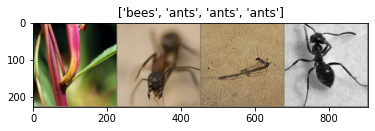

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(trainLoader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[x] for x in classes[0:4]])

# 4. Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

  pip install torch-lr-finder -v --global-option="amp"


# 5. Visualizing the model predictions
Generic function to display predictions for a few images

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


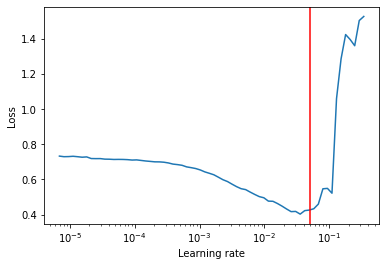

In [ ]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.05) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.05, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [ ]:
model_res = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6474 Acc: 0.6516
val Loss: 0.5197 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.5040 Acc: 0.7992
val Loss: 0.3657 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.3908 Acc: 0.8607
val Loss: 0.2583 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.2883 Acc: 0.9057
val Loss: 0.2218 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2641 Acc: 0.9221
val Loss: 0.2007 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.2138 Acc: 0.9508
val Loss: 0.1839 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2299 Acc: 0.9180
val Loss: 0.1783 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.2136 Acc: 0.9344
val Loss: 0.1762 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2058 Acc: 0.9344
val Loss: 0.1625 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2011 Acc: 0.9303
val Loss: 0.1589 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.1710 Acc: 0.9549
val Loss: 0.1910 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.1873 Acc: 0.9344
val Loss: 0.1527 Acc: 0.9608

Epoch 12/24
----------
t

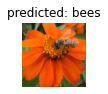

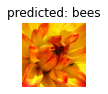

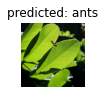

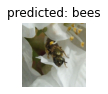

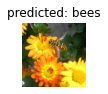

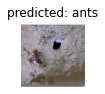

In [ ]:
visualize_model(model_res, dataloaders, class_names, device)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


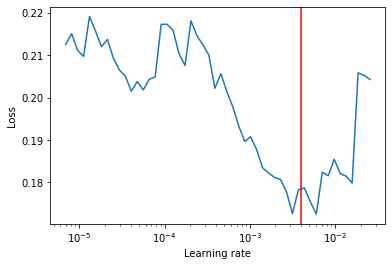

In [ ]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.004) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [ ]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.004, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

In [ ]:
model_final = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1961 Acc: 0.9098
val Loss: 0.1527 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.1828 Acc: 0.9303
val Loss: 0.1627 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1622 Acc: 0.9672
val Loss: 0.1498 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1912 Acc: 0.9221
val Loss: 0.1470 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1687 Acc: 0.9385
val Loss: 0.1461 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.1714 Acc: 0.9385
val Loss: 0.1428 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.1491 Acc: 0.9549
val Loss: 0.1483 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.1768 Acc: 0.9344
val Loss: 0.1385 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.1495 Acc: 0.9508
val Loss: 0.1369 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.1562 Acc: 0.9631
val Loss: 0.1470 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.1820 Acc: 0.9180
val Loss: 0.1364 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.1779 Acc: 0.9344
val Loss: 0.1654 Acc: 0.9281

Epoch 12/24
----------
t

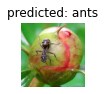

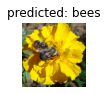

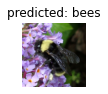

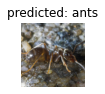

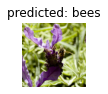

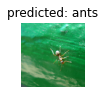

In [ ]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()